In [90]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# reading the files into our code
df = pd.read_csv("data/orders.csv", header=1)
df_intern = pd.read_csv("data/intern_with_day.csv")
df_campaign = pd.read_csv("data/campaign_data.csv")
df_process = pd.read_csv("data/order_process_data.csv")

# change the column names to lowercase and replace whitespace with an underscore
df.columns=df.columns.str.lower().str.replace(" ", "_") 
df_campaign.columns=df_campaign.columns.str.lower().str.replace(" ", "_")
df_intern.columns=df_intern.columns.str.lower().str.replace(" ", "_")
df_process.columns=df_process.columns.str.lower().str.replace(" ", "_")

# change the date to the same format across all dataframes 
df["order_date"] = pd.to_datetime(df["order_date"], dayfirst=True) 
df_process["on_truck_scan_date"] = pd.to_datetime(df_process["on_truck_scan_date"], format='mixed', dayfirst=True)
df_process["order_date"] = pd.to_datetime(df_process["order_date"], format='mixed', dayfirst=True)
df_campaign["arrival_scan_date"] = pd.to_datetime(df_campaign["arrival_scan_date"], format='mixed', dayfirst=True)
df_intern["ready_to_ship_date"] = pd.to_datetime(df_intern["ready_to_ship_date"], format='mixed', dayfirst=True)
df_intern["pickup_date"] = pd.to_datetime(df_intern["pickup_date"], format='mixed', dayfirst=True)

# get rid of whitespace 
df_campaign["order_id"] = df_campaign["order_id"].str.strip()

# drop column we don't need
df.drop(columns=["postal_code"], inplace=True)

# drop duplicates 
df_intern.drop_duplicates(inplace=True)  

Hypothesis 1: warehouse process migth take longer than expected (exp.: ~ 2d)


In [32]:
# create dataframe for internal warehouse process 
warehouse_pr = df_intern.merge(df, how = 'left', on = 'order_id')
warehouse_pr = warehouse_pr[['order_id', 'origin_channel', 'quantity', 'ship_mode', 'order_date', 'ready_to_ship_date', 'ready_to_ship_day']] 
warehouse_pr.drop_duplicates()

warehouse_pr['time'] = warehouse_pr['ready_to_ship_date'] - warehouse_pr['order_date'] 
print(warehouse_pr['time'].mean())

# look at mean and count for ship_mode
print(warehouse_pr.groupby('ship_mode')["time"].mean(),'\n')
print(warehouse_pr.groupby('ship_mode')["time"].count(),'\n') 

# create column for day of date 
warehouse_pr['order_day'] = warehouse_pr['order_date'].dt.day_name() 
df_intern["day"] = df_intern["ready_to_ship_date"].dt.day_name() 

# convert time to floating number in order to visualize data later on e.g. plot for H4
warehouse_pr['time'] = warehouse_pr['time'].dt.days.astype(float) 
print(warehouse_pr['time'].max())
print(warehouse_pr['time'].min())


4 days 03:47:22.105263157
ship_mode
First Class      1 days 21:52:56.470588235
Second Class     3 days 20:54:11.612903225
Standard Class   5 days 07:19:06.188340807
Name: time, dtype: timedelta64[ns] 

ship_mode
First Class       102
Second Class       93
Standard Class    223
Name: time, dtype: int64 

8.0
0.0


Hypothesis 1: Overall our hypothesis could be validated/confirmed as we can see that our mean value for the internal processing time (order > ready to ship) is ~4d. Furthermore the shipping mode seemes to have an influence on the processing time. We can see that there is deviation of ~ 2d depending on shipping mode.

Data check: influence of order day and shipping mode on the internal processing time (warehouse = order > ready to ship)

In [3]:

warehouse_pr['ready_to_ship_day'].value_counts()
warehouse_pr.groupby('order_day', as_index=False)['time'].mean() # (warehouse_pr['ship_mode']) 


,order_day,time
0,Friday,4.148649
1,Monday,3.797468
2,Saturday,4.517241
3,Sunday,6.400000
4,Thursday,4.014706
5,Tuesday,4.575000
6,Wednesday,3.963855


In [4]:
pd.pivot_table(warehouse_pr,
                values='time',
                index='order_day',
                columns='ship_mode',
                aggfunc='mean',
                fill_value=0) 

ship_mode,First Class,Second Class,Standard Class
order_day,,,
Friday,2.000000,3.600000,5.256410
Monday,1.866667,2.904762,4.906977
Saturday,3.800000,2.000000,4.909091
Sunday,0.000000,4.000000,8.000000
Thursday,2.150000,4.687500,4.843750
Tuesday,1.300000,4.176471,6.255814
Wednesday,1.814815,4.600000,5.146341


Hypothesis 3: the origin channel is influencing the internal processing time (warehouse = order > ready to ship)

In [5]:
origin_inf=pd.pivot_table(warehouse_pr,
                values='time',
               # index='order_day',
            
                columns='origin_channel',
                aggfunc='mean',
                fill_value=0)  

In [6]:
origin_inf = origin_inf.T 
#origin_inf['somethin_else']= [1,2,3]
origin_inf.reset_index(inplace = True) 

In [7]:
origin_inf


,origin_channel,time
0,Email,4.558140
1,Facebook,3.752809
2,Sales,3.719298


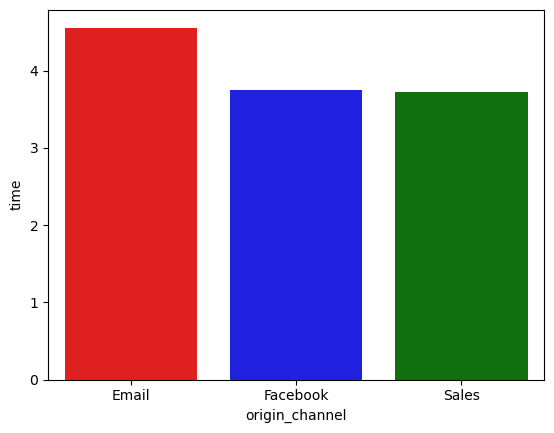

In [101]:
sns.barplot( data = origin_inf, x = 'origin_channel', y = 'time', palette=['r', 'b', 'g']);

Depending on the origin channel, the E-Mail channel tends to have a longer internal processing time of at least ~1d compared to the other available channels.
> proposal: E-Mail automation

Hypothesis 4: the quantity of the orders is influencing the internal processing time (warehouse = order > ready to ship)

In [9]:
# the time it takes from order to ready to ship depending on the quantity of the orders 
quantity_inf = pd.pivot_table(warehouse_pr,
                values='time',
                # index='time', 
                columns='quantity',
                aggfunc='mean',
                fill_value=0) 

quantity_inf

quantity,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,4.342105,4.190476,4.044444,3.959184,4.081633,3.884615,4.173913,5.0,4.384615,5.0,5.0,4.0,6.0,3.5


In [10]:
quantity_inf = quantity_inf.T 
quantity_inf['somethin_else']= [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
quantity_inf.reset_index(inplace = True) 

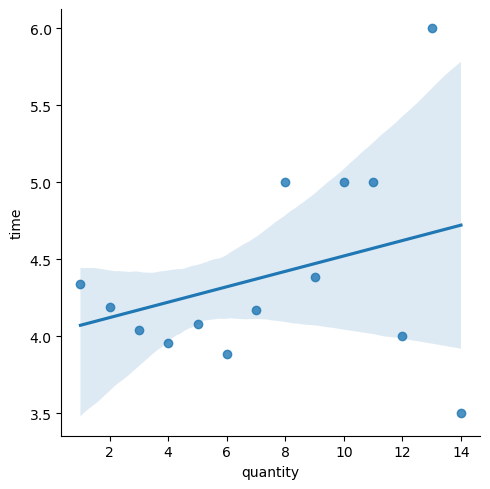

In [102]:
sns.lmplot( data = quantity_inf, x = 'quantity', y = 'time', palette=['r', 'g']) ;

for H4: we can't examine any correlation between the quantity of products per order and internal processing time (warehouse = order > ready to ship)

In [12]:
#df_dummies = pd.get_dummies(warehouse_pr.ship_mode)
#concat_df = pd.concat([df_dummies, warehouse_pr], axis=1) 

In [13]:
#concat_df.head() 

Hypothesis 2: last mile delivery time might by heavily dependend on delivery region.

In [14]:
last_mile = df_campaign.merge(df_process, how = 'left', on ='order_id')
last_mile['time'] = last_mile ['arrival_scan_date'] - last_mile['on_truck_scan_date'] 
last_mile

last_mile = last_mile.merge(df[['order_id','region']], how = 'left', on = 'order_id')

last_mile.groupby('region', as_index=False)['time'].mean() 

,region,time
0,Central,4 days 08:30:49.117174959
1,East,4 days 16:07:05.615763546
2,South,4 days 15:03:45.941422594
3,West,4 days 15:42:46.153846153


H2: based on data analysis, we cannot see any dependency of delivery region on the last mile delivery time.

Hypothesis 5: the amount of orders per day is influencing the internal processing time (warehouse = order > ready to ship)

            order_date      time     count
order_date    1.000000 -0.038523  0.329460
time         -0.038523  1.000000 -0.339804
count         0.329460 -0.339804  1.000000


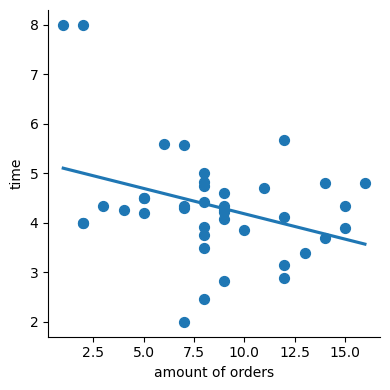

In [104]:
df_time = pd.pivot_table( warehouse_pr,
                values = 'time',
                index='order_date',
                aggfunc='mean',
                fill_value=0)  

# amount of orders per day

df_unique = df.copy()
df_unique.drop_duplicates(subset=['order_id'], inplace=True)

counts = df_unique['order_date'].value_counts() 
df_numberorders = pd.DataFrame(counts.reset_index()) 

df_time_count = df_time.merge(df_numberorders, on = 'order_date')
df_time_count.sort_values('count', ascending= False)

fig=sns.lmplot(data = df_time_count, x = 'count', y = 'time', palette="inferno", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}) 
fig.set_axis_labels('amount of orders', 'time')
print(df_time_count.corr()) 


H5: no direct correlation.

> assumption: warehouse workers tend to work faster when orders intake is high

Examine the monthly delivery times

In [47]:
df_season = df_process.copy()
df_season["month"] = df_season["order_date"].dt.month_name() 
df_season['time'] = df_season['on_truck_scan_date'] - df_season['order_date'] 
df_season['time'] = df_season['time'].dt.days.astype(float) 

In [96]:
df_season.groupby("month")["time"].mean()

month
April        6.198391
August       6.266497
December     6.291155
February     6.357895
January      6.643443
July         6.353630
June         5.817568
March        5.581047
May          6.012848
November     6.178528
October      6.170040
September    5.914842
Name: time, dtype: float64

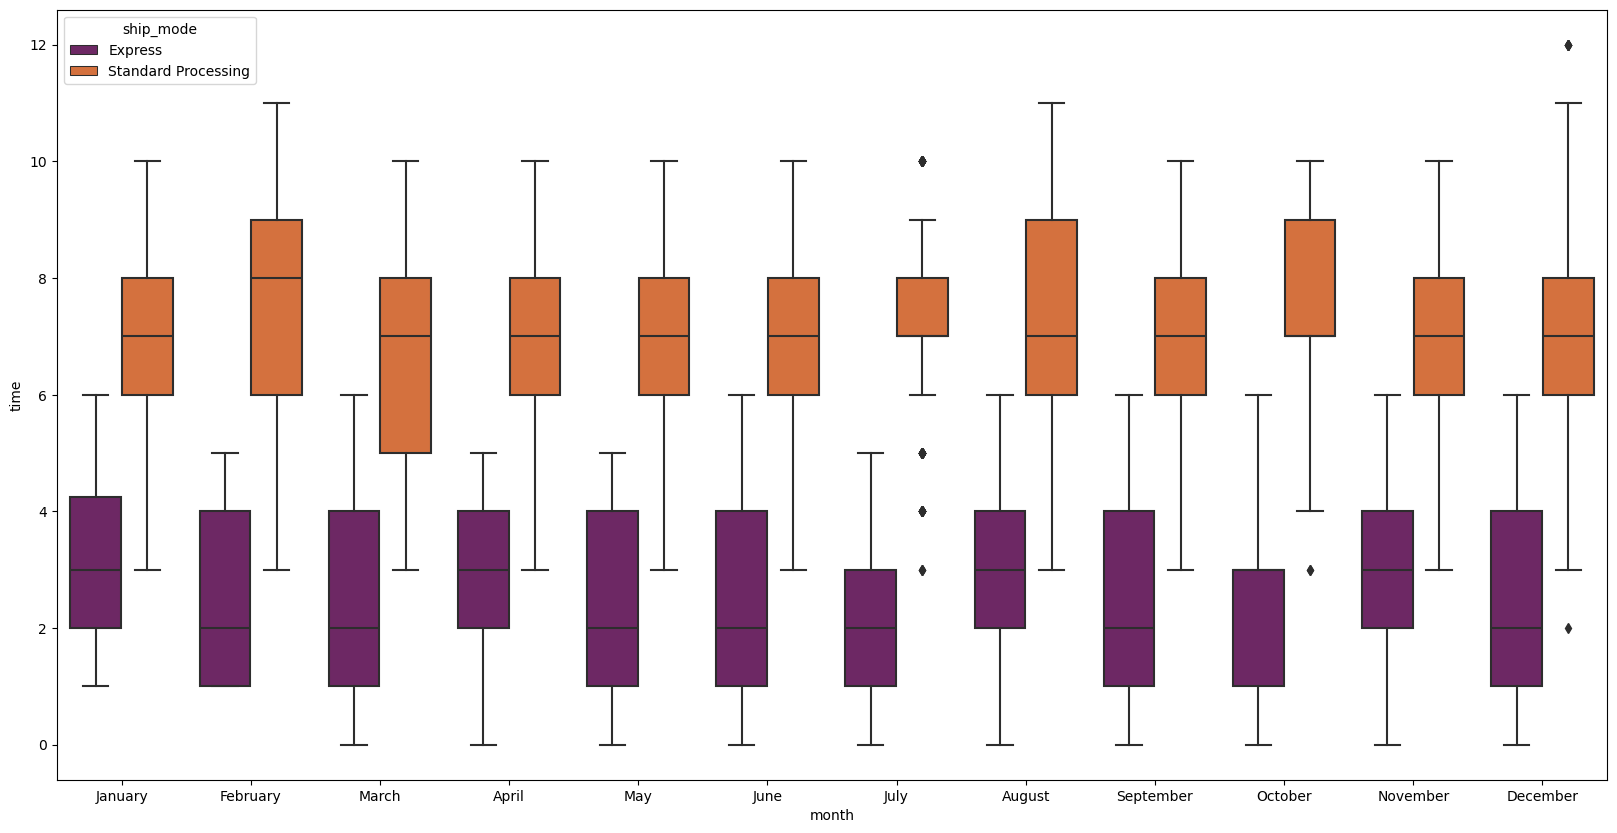

In [95]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_season, y="time", x="month", hue="ship_mode", palette="inferno");

                                        KPI's:                                                          

In [16]:
# shipping time 

print(last_mile['time'].mean())

4 days 13:34:33.151750972


In [17]:
# order lead time 

order_lead = df_campaign.merge(df, how = 'left', on ='order_id')

order_lead['time'] = order_lead['arrival_scan_date'] - order_lead['order_date']  
print(order_lead['time'].mean())

10 days 21:16:10.059880239


In [18]:
# pack cycle time 

warehouse_pr['time'] = warehouse_pr['ready_to_ship_date'] - warehouse_pr['order_date']
print(warehouse_pr['time'].mean()) 

4 days 03:47:22.105263157


In [19]:
# pick cycle 

pick_cycle = df_intern.merge(df_process, how = 'left', on ='order_id')
pick_cycle['time'] = pick_cycle['pickup_date'] - pick_cycle['ready_to_ship_date']
print(pick_cycle['time'].mean()) 

1 days 15:26:41.913875598
